In [71]:
%matplotlib inline

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

from lmfit import Parameters, Minimizer, minimize, report_fit

import scqubits as scq

scq.settings.FUZZY_SLICING = True

In [73]:
osc = scq.Oscillator(E_osc = 1)
gq = scq.GenericQubit(E = 1)

g = 0.1
hilbertspace = scq.HilbertSpace([gq, osc])

hilbertspace.add_interaction(
    g_strength = g,
    op1 = osc.annihilation_operator,
    op2 = gq.sp_operator,
    add_hc = True
)

In [74]:
def update_hilbertspace(E, detuning):
    gq.E = E
    osc.E_osc = E + detuning

x = np.linspace(0, 10, 201)

pname1 = 'E'
E_vals = x
pname3 = 'detuning'
detuning_vals = x

paramvals_by_name = {pname1: E_vals, pname3: detuning_vals}

sweep = scq.ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name=paramvals_by_name,
    update_hilbertspace=update_hilbertspace,
    evals_count=4,
    num_cpus=4
)

Parallel compute bare eigensys [num_cpus=4]

Parallel compute bare eigensys [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

In [75]:
def create_interpolated_data(x, egv, e):
    egv_x = np.linspace(0, egv-1, egv)
    points = (x, x, egv_x)
    values = sweep["evals"]
    
    matrix = np.zeros((x.size,4))
    row_index = 0
    for i in x:
        column_index = 0
        for j in egv_x:
            matrix[row_index, column_index] = interpolate.interpn(points, values, np.array([e, i, j]))[0]
            column_index+=1
        row_index+=1
    return matrix

In [76]:
def jc_resid(pars, x, data=None):
    e = pars['e']
    
    model = create_interpolated_data(x, 4, e)
    if data is None:
        return model
    #return model - data
    resid = model - data
    return resid.flatten()

params = Parameters()
params.add('e', value=3.4, min = 0, max = 10)

e = 8.1
jc_data = create_interpolated_data(x, 4, e)
jc_noise = jc_data + 0.4*np.random.normal(size=jc_data.shape)

min1 = Minimizer(jc_resid, params, fcn_args=(x,), fcn_kws={'data': jc_noise})
out1 = min1.leastsq()
fit1 = jc_resid(out1.params, x)
report_fit(out1.params)

out2 = minimize(jc_resid, params, args=(x, jc_noise))
fit2 = jc_resid(out2.params, x)
report_fit(out2.params)

[[Variables]]
    e:  8.09772459 +/- 0.01572103 (0.19%) (init = 3.4)
[[Variables]]
    e:  8.09772459 +/- 0.01572103 (0.19%) (init = 3.4)


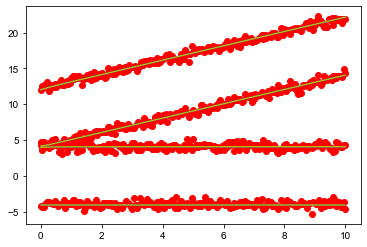

In [77]:
plt.plot(x, jc_noise, 'ro')
plt.plot(x, fit1, 'b')
plt.plot(x, fit2, 'y')
plt.show()